In [1]:
import tensorflow as tf
import tensorflow_federated as tff
import nest_asyncio

In [2]:
# Apply nest_asyncio to enable nested event loops
nest_asyncio.apply()

In [3]:
# Load the CIFAR-10 dataset
(cifar10_train_images, cifar10_train_labels), (cifar10_test_images, cifar10_test_labels) = tf.keras.datasets.cifar10.load_data()

In [4]:
# Preprocess the dataset
def preprocess(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return (images, labels)

In [5]:
# Split the dataset into multiple "client" datasets
num_clients = 10
client_datasets = []
for i in range(num_clients):
    start = i * len(cifar10_train_images) // num_clients
    end = (i + 1) * len(cifar10_train_images) // num_clients
    client_images = cifar10_train_images[start:end]
    client_labels = cifar10_train_labels[start:end]
    client_dataset = tf.data.Dataset.from_tensor_slices((client_images, client_labels))
    client_dataset = client_dataset.map(preprocess).batch(20)
    client_datasets.append(client_dataset)

In [6]:
# Define a simple CNN model
def create_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    return model

In [7]:
# Define a TFF model
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [8]:
# Create a federated averaging process
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

In [9]:
# Initialize the federated averaging process
state = iterative_process.initialize()

In [10]:
# Run multiple rounds of federated averaging
NUM_ROUNDS = 10
for round_num in range(NUM_ROUNDS):
    state, metrics = iterative_process.next(state, client_datasets)
    print('round {:2d}, metrics={}'.format(round_num, metrics))


round  0, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.16786), ('loss', 2.2202466)]))])
round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.25386), ('loss', 2.0403335)]))])
round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.30676), ('loss', 1.9261584)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.34924), ('loss', 1.8171703)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_p

In [11]:
def evaluate_model(state, test_dataset):
    keras_model = create_keras_model()
    keras_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    state.model.assign_weights_to(keras_model)
    
    test_images, test_labels = zip(*list(test_dataset))
    test_images = tf.concat(test_images, axis=0)
    test_labels = tf.concat(test_labels, axis=0)
    
    loss, accuracy = keras_model.evaluate(test_images, test_labels, verbose=0)
    return loss, accuracy

test_dataset = tf.data.Dataset.from_tensor_slices((cifar10_test_images, cifar10_test_labels))
test_dataset = test_dataset.map(preprocess).batch(20)

loss, accuracy = evaluate_model(state, test_dataset)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


Test loss: 1.3648767471313477, Test accuracy: 0.5156999826431274


round  0, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.49564), ('loss', 1.4113637)]))])
round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.50858), ('loss', 1.3819643)]))])
round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.5191), ('loss', 1.3542517)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.52998), ('loss', 1.3277857)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_pr

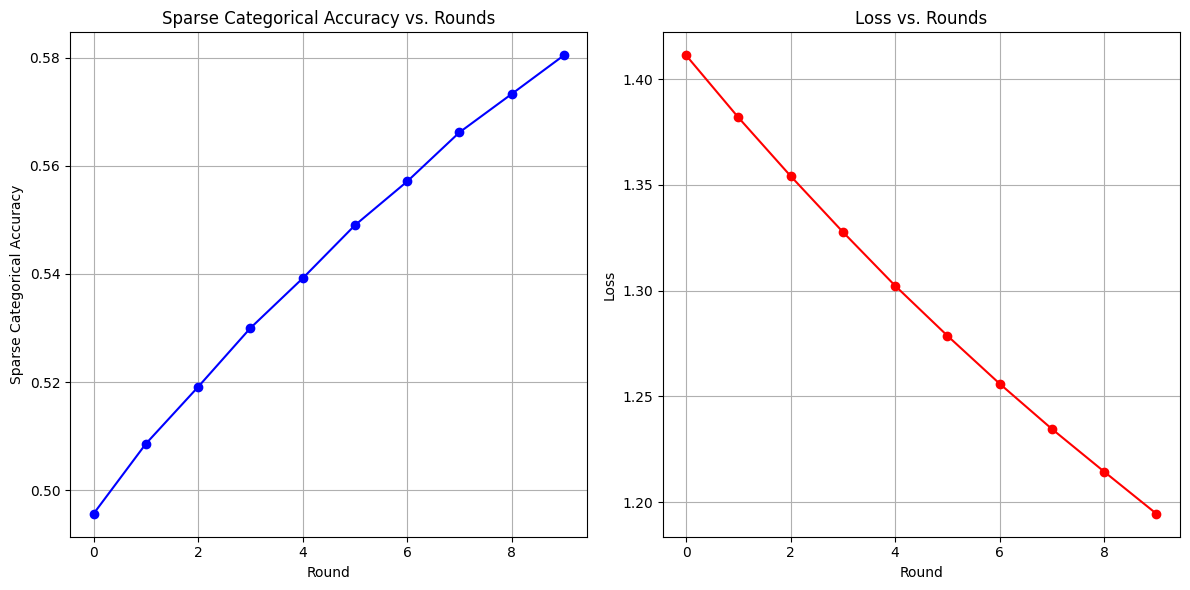

In [17]:
import matplotlib.pyplot as plt

# Store metrics for plotting
rounds = []
sparse_categorical_accuracies = []
losses = []

# Run multiple rounds of federated averaging
NUM_ROUNDS = 10
for round_num in range(NUM_ROUNDS):
    state, metrics = iterative_process.next(state, client_datasets)
    rounds.append(round_num)
    sparse_categorical_accuracies.append(metrics['train']['sparse_categorical_accuracy'])
    losses.append(metrics['train']['loss'])
    print(f'round {round_num:2d}, metrics={metrics}')

# Plotting
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(rounds, sparse_categorical_accuracies, marker='o', linestyle='-', color='b')
plt.title('Sparse Categorical Accuracy vs. Rounds')
plt.xlabel('Round')
plt.ylabel('Sparse Categorical Accuracy')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(rounds, losses, marker='o', linestyle='-', color='r')
plt.title('Loss vs. Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
!pip install matplotlib

  Using cached matplotlib-3.5.3-cp37-cp37m-win_amd64.whl (7.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.5-cp37-cp37m-win_amd64.whl (55 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached Pillow-9.5.0-cp37-cp37m-win_amd64.whl (2.5 MB)
  Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
